In [4]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn.functional as F

import pickle as pickle
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

# 아래 2개 경로만 설정.
SAVE_PATH = "../../code/no_relation_results_1/checkpoint-5000" # huggingface checkpoint folder.
test_dataset_dir = "../../dataset/valid/valid2/valid_20.csv" # csv file that you wnat to see result from model.


class RE_Dataset(torch.utils.data.Dataset):
  """ Dataset 구성을 위한 class."""
  def __init__(self, pair_dataset, labels):
    self.pair_dataset = pair_dataset
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def preprocessing_dataset(dataset):
  """ 처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
  subject_entity = []
  object_entity = []
  for i,j in zip(dataset['subject_entity'], dataset['object_entity']):
    i = i[1:-1].split(',')[0].split(':')[1]
    j = j[1:-1].split(',')[0].split(':')[1]

    subject_entity.append(i)
    object_entity.append(j)
  out_dataset = pd.DataFrame({'id':dataset['id'], 'sentence':dataset['sentence'],'subject_entity':subject_entity,'object_entity':object_entity,'label':dataset['label'],})
  return out_dataset

def load_data(dataset_dir):
  """ csv 파일을 경로에 맡게 불러 옵니다. """
  pd_dataset = pd.read_csv(dataset_dir)
  dataset = preprocessing_dataset(pd_dataset)
  
  return dataset

def tokenized_dataset(dataset, tokenizer):
  """ tokenizer에 따라 sentence를 tokenizing 합니다."""
  concat_entity = []
  for e01, e02 in zip(dataset['subject_entity'], dataset['object_entity']):
    temp = ''
    temp = e01 + '[SEP]' + e02
    concat_entity.append(temp)
  tokenized_sentences = tokenizer(
      concat_entity,
      list(dataset['sentence']),
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=256,
      add_special_tokens=True,
      )
  return tokenized_sentences

with open(os.path.join(SAVE_PATH, "config.json"), 'r') as f:
    training_config = json.load(f)
    Tokenizer_NAME = training_config["_name_or_path"]

# 라벨 목록 (수가 제일 많은 라벨부터.)
# label_indices = "no_relation" 없는 라벨 리스트.
label_list = [
    "no_relation", "org:top_members/employees", "per:employee_of", "per:title", "org:member_of",
    "org:alternate_names", "per:origin", "org:place_of_headquarters", "per:date_of_birth", "per:alternate_names",
    "per:spouse", "per:colleagues", "per:parents", "org:founded", "org:members", "per:date_of_death", "org:product",
    "per:children", "per:place_of_residence", "per:other_family", "per:place_of_birth", "org:founded_by", "per:product",
    "per:siblings", "org:political/religious_affiliation", "per:religion", "per:schools_attended", "org:dissolved",
    "org:number_of_employees/members", "per:place_of_death", 
]
no_relation_label_idx = label_list.index("no_relation")
label_indices = list(range(len(label_list)))
label_indices.remove(no_relation_label_idx)

def label_to_num(label):
    num_label = []
    with open('source/dict_label_to_num.pkl', 'rb') as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])

    return num_label

def num_to_label(label):
    """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
    """
    origin_label = []
    with open('source/dict_num_to_label.pkl', 'rb') as f:
        dict_num_to_label = pickle.load(f)
    for v in label:
        origin_label.append(dict_num_to_label[v])

    return origin_label

def inference(model, tokenized_sent, device):
    """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
    """
    dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
    model.eval()
    output_pred = []
    output_prob = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data['input_ids'].to(device),
                attention_mask=data['attention_mask'].to(device),
                token_type_ids=data['token_type_ids'].to(device)
                )
        logits = outputs[0]
        prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)

        output_pred.append(result)
        output_prob.append(prob)

    return np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

def klue_re_auprc(probs, labels):
    """KLUE-RE AUPRC (with no_relation)"""
    labels = np.eye(30)[labels]

    score = np.zeros((30,))
    precisions, recalls = [], []
    for c in range(30):
        targets_c = labels.take([c], axis=1).ravel()
        preds_c = probs.take([c], axis=1).ravel()
        precision, recall, _ = precision_recall_curve(targets_c, preds_c)
        precisions.append(precision)
        recalls.append(recall)
        score[c] = auc(recall, precision)
    return np.average(score) * 100.0, precisions, recalls, score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("load tokenizer...")
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

print("load model...")
## load my model
model = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH)
model.to(device)

print("set dataset...")
# set dataset
test_dataset = load_data(test_dataset_dir)

test_label = label_to_num(test_dataset['label'].values)
tokenized_test = tokenized_dataset(test_dataset, tokenizer)
RE_test_dataset = RE_Dataset(tokenized_test, test_label)
print("Done!")

load tokenizer...
load model...
set dataset...
Done!


In [5]:
# 모델 결과 예측.
pred_answer, output_prob = inference(model, RE_test_dataset, device)

100%|██████████| 406/406 [00:29<00:00, 13.73it/s]


In [4]:
# get score of model

f1 = f1_score(test_label, pred_answer, average="micro", labels=label_indices)
acc = accuracy_score(test_label, pred_answer)
auprc, precision, recall, score = klue_re_auprc(np.array(output_prob), test_label)

print("micro-f1 score :", f1)
print("accuracy :", acc)
print("auprc :", auprc)

micro-f1 score : 0.7436268305912132
accuracy : 0.6343306600863664
auprc : 66.27914081651377


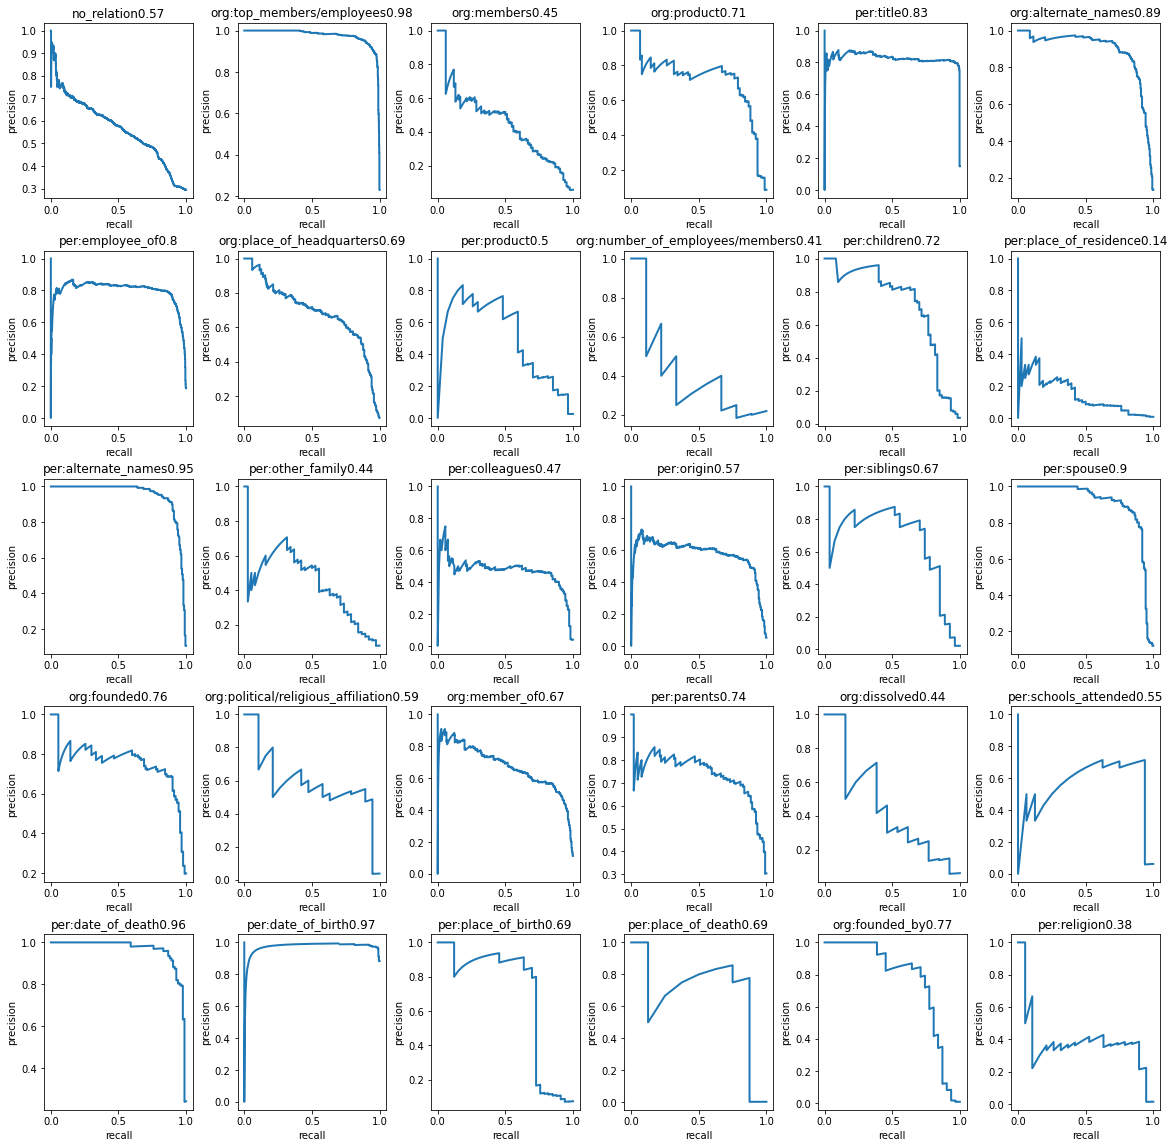

In [6]:
# plot precision-recall graph from all labels.

fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i in range(30):
    ax[i//6][i%6].plot(recall[i], precision[i], lw=2)
    ax[i//6][i%6].set_xlabel("recall")
    ax[i//6][i%6].set_ylabel("precision")
    ax[i//6][i%6].set_title(label_list[i]+str(np.round(score[i], 2)))
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['no_relation', 'org:top_members/employees', 'org:members', 'org:product', 'per:title', 'org:alternate_names', 'per:employee_of', 'org:place_of_headquarters', 'per:product', 'org:number_of_employees/members', 'per:children', 'per:place_of_residence', 'per:alternate_names', 'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings', 'per:spouse', 'org:founded', 'org:political/religious_affiliation', 'org:member_of', 'per:parents', 'org:dissolved', 'per:schools_attended', 'per:date_of_death', 'per:date_of_birth', 'per:place_of_birth', 'per:place_of_death', 'org:founded_by', 'per:religion'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


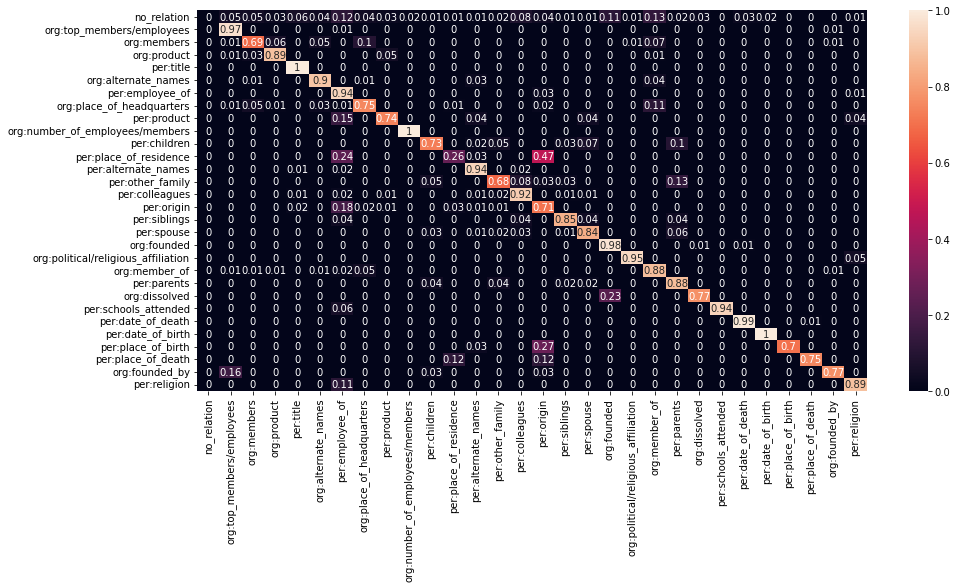

In [10]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sn


df = pd.read_csv(test_dataset_dir)
df["pred"] = num_to_label(pred_answer)
df["output_prob"] = output_prob

cf_matrix = confusion_matrix(df["label"], df["pred"], label_list, normalize='true')

df_cm = round(pd.DataFrame(cf_matrix, index = [i for i in label_list],
                     columns = [i for i in label_list]), 2)
plt.figure(figsize = (15,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [11]:
# save result of valid csv file.
df.to_csv("./result_on_devs/no_relation1.csv", index=False)

In [14]:
# matplotlib 한글 출력을 위한 코드
from matplotlib import font_manager, rc

# ttf 파일은 직접 다운 받아서 경로 지정.
font_path = "../nanum-gothic/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [12]:
# Draw attention map.

# 입력 문장
sentence = df["sentence"][0]

encoded = tokenizer(sentence, return_tensors='pt')
encoded = encoded.to(device)

# output_attentions=True 옵션으로 attention map을 출력 가능.
output = model(encoded['input_ids'], encoded['attention_mask'], output_attentions=True, return_dict=True)
attention = output.attentions
attention = torch.stack(attention).squeeze().detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])
print(attention.shape)
# (num_layer, num_attention_head, sequence_length,sequence_length)

(12, 12, 55, 55)


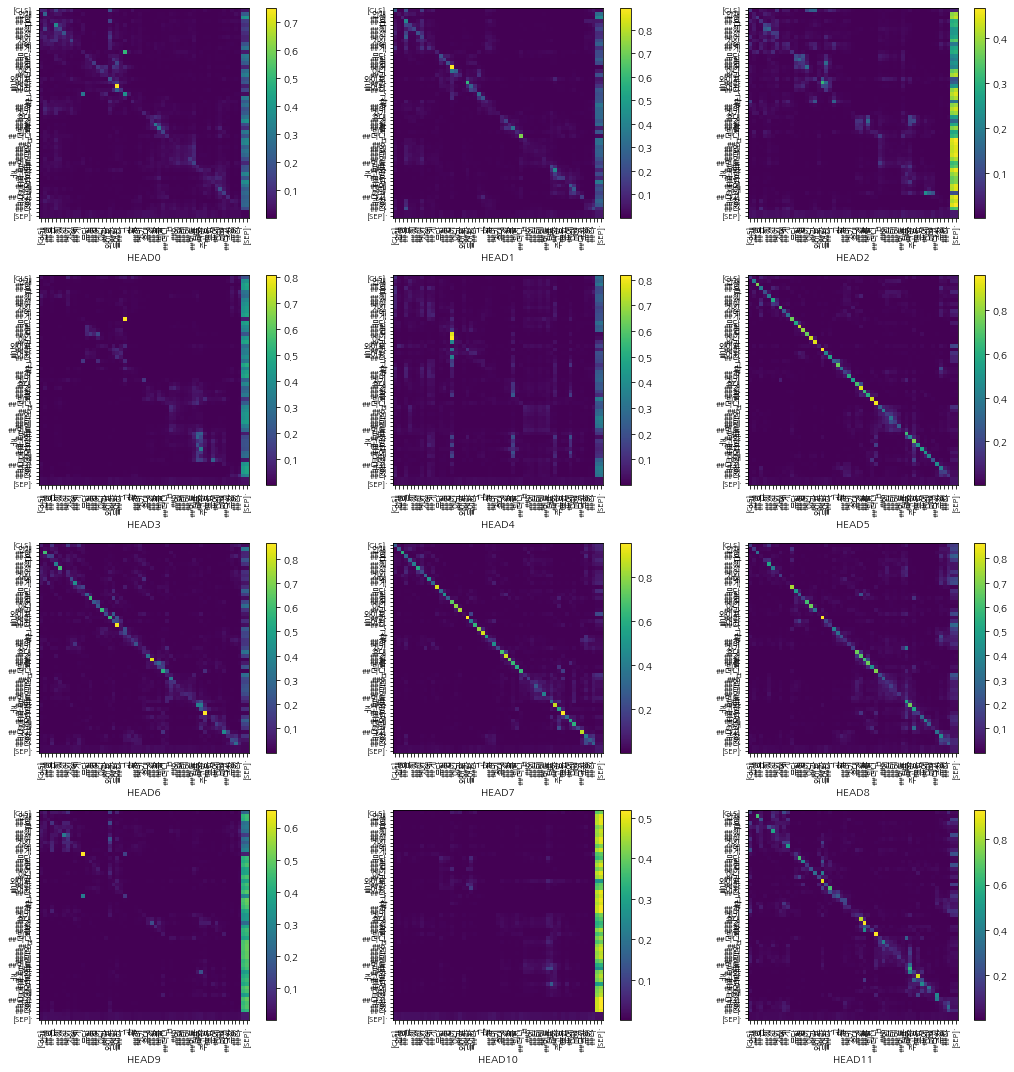

In [15]:
# 몇 번째 BERT 레이어의 output을 볼 건지.
target_layer = -1

# 각 attention head가 보는 부분을 시각화.
fig = plt.figure(figsize=(15,15))
fontdict = {'fontsize': 8}
num_token = len(tokens)

for head_idx, head_score in enumerate(attention[target_layer]):
    ax = fig.add_subplot(4, 3, head_idx+1)
    img = ax.imshow(np.array(head_score))
    ax.set_xticks(range(num_token))
    ax.set_yticks(range(num_token))
    ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(tokens, fontdict=fontdict)
    ax.set_xlabel('HEAD'+str(head_idx))
    fig.colorbar(img)
plt.tight_layout()
plt.show()

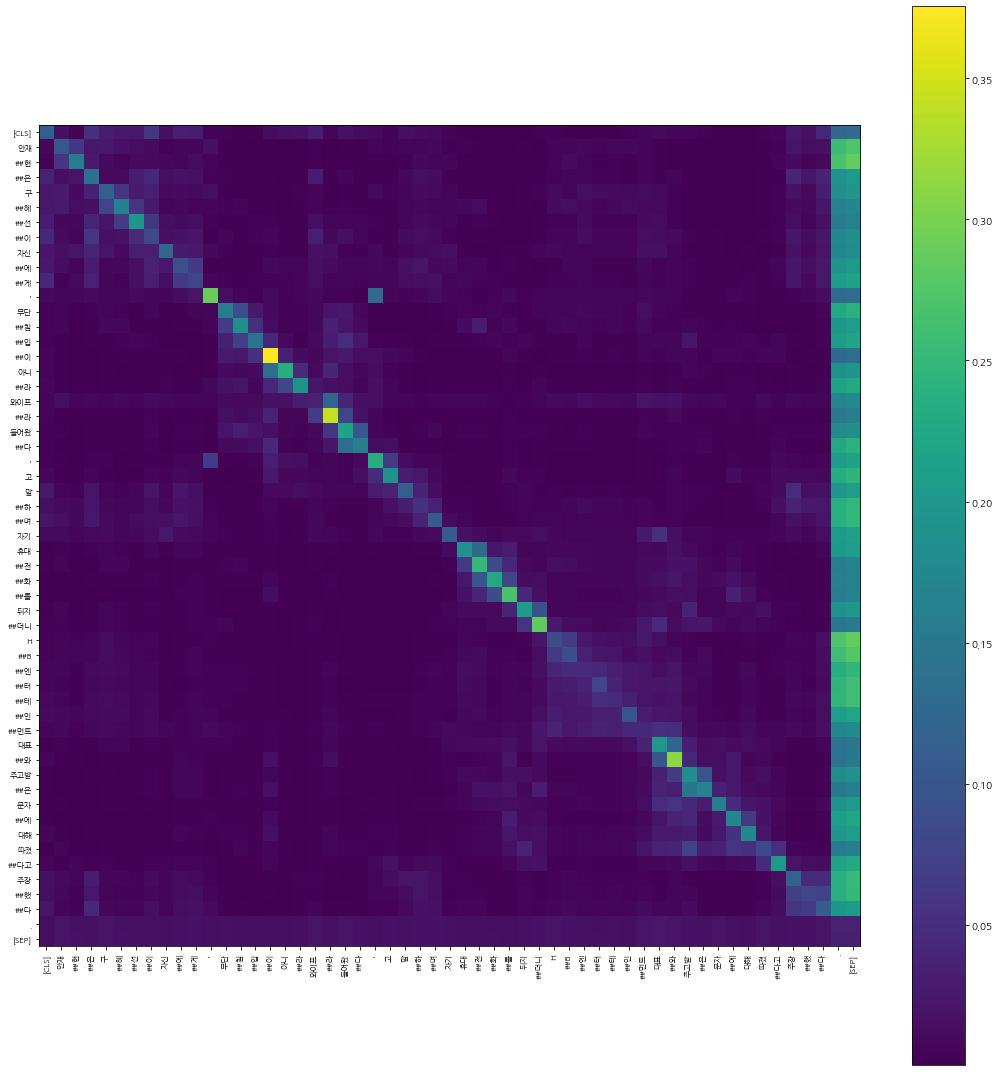

In [20]:
# 몇 번째 BERT 레이어의 output을 볼 건지.
target_layer = -1

# 각 attention head가 보는 부분을 시각화.
fig = plt.figure(figsize=(15,15))
fontdict = {'fontsize': 8}
num_token = len(tokens)

# 12개의 head를 모두 확인하는 것은 힘드니까 12개 head의 값의 평균을 계산해서 시각화.
# 이와 같은 방법으로 bert layer들도 모두 평균내서 시각화할 수도 있다. 그건 알아서...
mean_attn = np.mean(attention[target_layer], axis=0)
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(np.array(mean_attn))

ax.set_xticks(range(num_token))
ax.set_yticks(range(num_token))
ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)
ax.set_yticklabels(tokens, fontdict=fontdict)
fig.colorbar(img)
plt.tight_layout()
plt.show()